# Исследование объявлений о продаже квартир

Имеются данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Это учебная задача Яндекс.Практикума. Цель - ответить на несколько вопросов к данным, прежде всего понять, какие параметры влияют на стоимость недвижимости. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

Описание данных:

- airports_nearest — расстояние до ближайшего аэропорта в метрах (м)
- balcony — число балконов
- ceiling_height — высота потолков (м)
- cityCenters_nearest — расстояние до центра города (м)
- days_exposition — сколько дней было размещено объявление (от публикации до снятия)
- first_day_exposition — дата публикации
- floor — этаж
- floors_total — всего этажей в доме
- is_apartment — апартаменты (булев тип)
- kitchen_area — площадь кухни в квадратных метрах (м²)
- last_price — цена на момент снятия с публикации
- living_area — жилая площадь в квадратных метрах(м²)
- locality_name — название населённого пункта
- open_plan — свободная планировка (булев тип)
- parks_around3000 — число парков в радиусе 3 км
- parks_nearest — расстояние до ближайшего парка (м)
- ponds_around3000 — число водоёмов в радиусе 3 км
- ponds_nearest — расстояние до ближайшего водоёма (м)
- rooms — число комнат
- studio — квартира-студия (булев тип)
- total_area — площадь квартиры в квадратных метрах (м²)
- total_images — число фотографий квартиры в объявлении

Пояснение: апартаменты — это нежилые помещения, не относящиеся к жилому фонду, но имеющие необходимые условия для проживания.

### Оглавление

1. [Открытие данных](#start)
2. [Предобработка данных](#preprocessing)
3. [Добавляем новые столбцы](#newcolumns)
4. [Исследовательский анализ данных](#exploratoryanalysis)
   * [Какие факторы больше всего влияют на стоимость квартиры?](#pricefactors)
   * [Населенные пункты и стоимость жилья](#localitiesandprices)
   * [Определяем границы центра Санкт-Петербурга](#center)
   * [Особенности квартир в центре](#downtownfacts)  
   
   
5. [Общие выводы](#generalconclusion)
   
   



### Шаг 1. Открытие данных <a id="start"></a>

In [ ]:
import pandas as pd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('/datasets/real_estate_data.csv',sep='\t')
display(df.head(5))
df.info()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

В некоторых столбцах, которые нужны для исследования, есть пропуски: living_area, kitchen_area, ceiling_height, locality_name, cityCenters_nearest. Заполнять их не будем, так как нет очевидного способа это сделать без порчи данных.

### Шаг 2. Предобработка данных <a id="preprocessing"></a>

In [ ]:
df['balcony'] = df['balcony'].fillna(0)
display(df['balcony'].value_counts())
df['is_apartment'].value_counts()

0.0    15277
1.0     4195
2.0     3659
5.0      304
4.0      183
3.0       81
Name: balcony, dtype: int64

False    2725
True       50
Name: is_apartment, dtype: int64

Если не указано количество балконов, скорее всего, его нет - заполнил пропуски нулем. Нельзя сделать тот же вывод про апартаменты, потому что в большинстве ячеек в столбце is_apartment указано, что это не апартаменты, поэтому никак не заполнял пропущенные значения. Оставил нетронутыми и другие столбцы с пропущенными значениями: нет очевидных способов избавиться от пропусков. Возможные причины пропусков:

living area, kitchen_area: не везде кухни отделены от жилой зоны

ceiling_height: не указали этот параметр, потому что не знают или не считают важным указать

locality_name, cityCenters_nearest: возможно, объекты находятся далеко от крупных населенных пунктов

In [ ]:
df['balcony']= df['balcony'].astype('int64')
df['floor']= df['floor'].astype('int64')
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null datetime64[ns]
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 23699 non-null int64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_aro

Из столбцов с числовыми значениями перевел в тип int64 только те столбцы, где нет пропущенных значений и где невозможны дробные значения. Столбец first_day_exposition перевел в формат datetime.

#### Убираем редкие и выбивающиеся значения

In [ ]:
df = df[(np.abs(stats.zscore(df['last_price'])) < 3)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23496 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23496 non-null int64
last_price              23496 non-null float64
total_area              23496 non-null float64
first_day_exposition    23496 non-null datetime64[ns]
rooms                   23496 non-null int64
ceiling_height          14369 non-null float64
floors_total            23411 non-null float64
living_area             21617 non-null float64
floor                   23496 non-null int64
is_apartment            2750 non-null object
studio                  23496 non-null bool
open_plan               23496 non-null bool
kitchen_area            21241 non-null float64
balcony                 23496 non-null int64
locality_name           23447 non-null object
airports_nearest        17961 non-null float64
cityCenters_nearest     17981 non-null float64
parks_around3000        17982 non-null float64
parks_nearest           7925 non-null float64
ponds_aro

Убрали около 500 слишком дорогих или дешевых квартир по столбцу last_price. 

### Вывод

Заполнили пропуски в столбцев 'balcony', удалили строки, где цена сильно выбивается. Не стали удалять строки с выбивающимися значениями в других столбцах, так как потеряли бы много ценных данных. Пропуски в большинстве столбцов тоже не трогали. Пропусков много: только в 10 столбцах из 22 данные полны.

### Шаг 3. Добавляем в таблицу новые столбцы <a id="newcolumns"></a>

In [ ]:
def floor_category(row):
    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    else:
        return 'другой'

df['price_per_square_meter'] = df['last_price'] / df['total_area']
df['weekday'] = df['first_day_exposition'].dt.weekday
df['month'] = df['first_day_exposition'].dt.month
df['year'] = df['first_day_exposition'].dt.year
df['floor_category'] = df.apply(floor_category,axis=1)
df['living_total_area_ratio'] = df['living_area'] / df['total_area']
df['kitchen_total_area_ratio'] = df['kitchen_area'] / df['total_area']
df.head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,price_per_square_meter,weekday,month,year,floor_category,living_total_area_ratio,kitchen_total_area_ratio
0,20,13000000.0,108.0,2019-03-07,3,2.70,16.0,51.0,8,NaN,...,2.0,755.0,NaN,120370.370370,3,3,2019,другой,0.472222,0.231481
1,7,3350000.0,40.4,2018-12-04,1,NaN,11.0,18.6,1,NaN,...,0.0,NaN,81.0,82920.792079,1,12,2018,первый,0.460396,0.272277
2,10,5196000.0,56.0,2015-08-20,2,NaN,5.0,34.3,4,NaN,...,2.0,574.0,558.0,92785.714286,3,8,2015,другой,0.612500,0.148214
4,2,10000000.0,100.0,2018-06-19,2,3.03,14.0,32.0,13,NaN,...,1.0,48.0,121.0,100000.000000,1,6,2018,другой,0.320000,0.410000
5,10,2890000.0,30.4,2018-09-10,1,NaN,12.0,14.4,5,NaN,...,NaN,NaN,55.0,95065.789474,0,9,2018,другой,0.473684,0.299342


Добавил столбцы с ценой за квадратный метр, отношением жилой площади к общей и площади кухни к общей, днем недели, месяцем и годом публикации объявления, а также категорией этажа.

### Шаг 4. Исследовательский анализ данных: <a id="exploratoryanalysis"></a>

count    23496.000000
mean        58.854875
std         29.879026
min         12.000000
25%         40.000000
50%         52.000000
75%         69.000000
max        470.300000
Name: total_area, dtype: float64

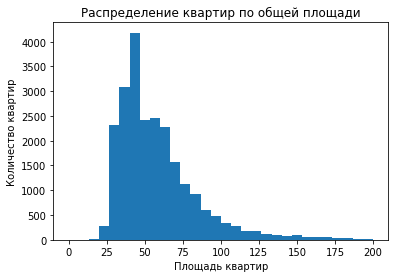

In [ ]:
display(df['total_area'].describe())
plt.hist(x=df['total_area'],range=(0,200), bins=30)
plt.title('Распределение квартир по общей площади')
plt.xlabel('Площадь квартир')
plt.ylabel('Количество квартир')

plt.show();

Медианная площадь - 52 кв. м., площадь половина квартир находится в промежутке от 40 до 69.9 кв. м. Минимальное и максимальное значения в 12 и 900 кв. м. соответственно выглядят правдоподобно.

count    2.349600e+04
mean     5.882134e+06
std      4.503258e+06
min      1.219000e+04
25%      3.400000e+06
50%      4.600000e+06
75%      6.700000e+06
max      3.900000e+07
Name: last_price, dtype: float64

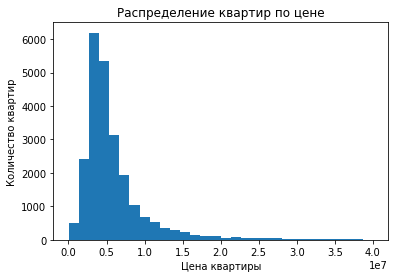

In [ ]:
display(df['last_price'].describe())

plt.hist(x=df['last_price'],range=(1.219000e+04, 4.000000e+07), bins=30)
plt.title('Распределение квартир по цене')
plt.xlabel('Цена квартиры')
plt.ylabel('Количество квартир')

plt.show();

Медианная стоимость квартиры - 4.6 млн рублей. Минимальное значение в 121 тысячу рублей, возможно, комната в коммуналке или гараж. Данные выглядят правдоподобно.

count    23496.000000
mean         2.050987
std          1.048005
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

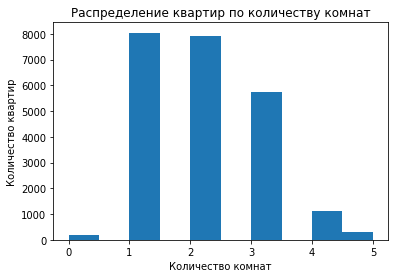

In [ ]:
display(df['rooms'].describe())
plt.hist(x=df['rooms'],range=(0, 5))
plt.title('Распределение квартир по количеству комнат')
plt.xlabel('Количество комнат')
plt.ylabel('Количество квартир')

plt.show();

Не ясно, откуда взялось 197 квартир без комнат. Больше всего однокомнатных и двухкомнатных. Трехкомнатных меньше - по всей видимости, тут много домов в новостройках, где трехкомнатные редки, так как менее ликвидны.

count    14369.000000
mean         2.765449
std          1.264219
min          1.000000
25%          2.510000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

Количество аномальных значений: 30


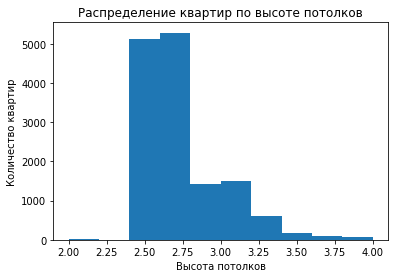

In [ ]:
display(df['ceiling_height'].describe())
print(f"Количество аномальных значений: {df[(df['ceiling_height'] > 7) | (df['ceiling_height'] < 1.1)]['ceiling_height'].count()}")
plt.hist(x=df['ceiling_height'],range=(2, 4))
plt.title('Распределение квартир по высоте потолков')
plt.xlabel('Высота потолков')
plt.ylabel('Количество квартир')

plt.show();

Максимальное значение, 100 метров, вызывает вопросы. Всего в 30 квартирах потолки выше 7 м или ниже 1.1 метра.

count    20362.000000
mean       179.827031
std        218.867161
min          1.000000
25%         45.000000
50%         95.000000
75%        229.750000
max       1580.000000
Name: days_exposition, dtype: float64

5% квартир продаются дольше 641.9500000000007 дней
5% квартир продаются быстрее 9.0 дней


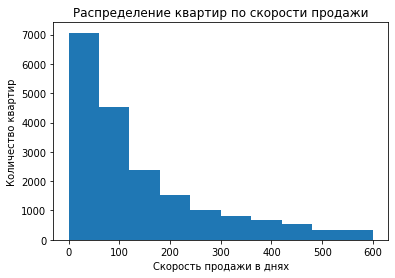

In [ ]:
display(df['days_exposition'].describe())
print(f"5% квартир продаются дольше {df['days_exposition'].quantile(q=0.95)} дней")
print(f"5% квартир продаются быстрее {df['days_exposition'].quantile(q=0.05)} дней")
plt.hist(x=df['days_exposition'],range=(0, 600))
plt.title('Распределение квартир по скорости продажи')
plt.xlabel('Скорость продажи в днях')
plt.ylabel('Количество квартир')

plt.show();

Медианное время продажи квартиры - 95 дней. Если квартира продается меньше, чем за 9 дней, то можем предположить, что она продается быстро - только 5% квартир продаются быстрее. Если продается дольше 642 дней, значит, продается долго - только 5% продаются медленнее.

### Какие факторы больше всего влияют на стоимость квартиры? <a id="pricefactors"></a>


0.7901652163715591

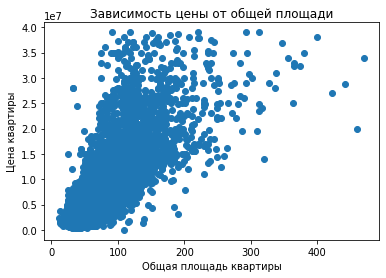

In [ ]:
display(df['total_area'].corr(df['last_price']))
#df.plot(x='total_area', y='last_price', kind='scatter', grid=True)
plt.scatter(x=df['total_area'], y=df['last_price'])
plt.title('Зависимость цены от общей площади')
plt.xlabel('Общая площадь квартиры')
plt.ylabel('Цена квартиры')

plt.show();

Между площадью и ценой есть достаточно высокий коэффициент корреляции - 0.79. Зависимость есть, это ожидаемо.

0.5226293093126603

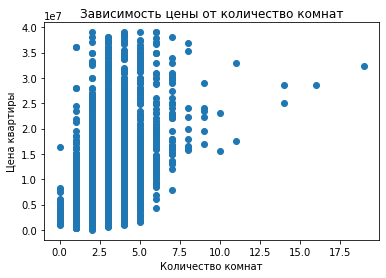

In [ ]:
display(df['rooms'].corr(df['last_price']))
#df.plot(x='rooms', y='last_price', kind='scatter', grid=True)
plt.scatter(x=df['rooms'], y=df['last_price'])
plt.title('Зависимость цены от количество комнат')
plt.xlabel('Количество комнат')
plt.ylabel('Цена квартиры')

plt.show();

От числа комнат стоимость зависит меньше, чем от площади.

-0.338627403267074

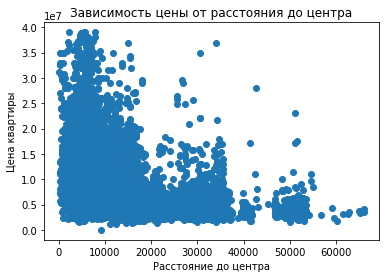

In [ ]:
display(df['cityCenters_nearest'].corr(df['last_price']))
plt.scatter(x=df['cityCenters_nearest'], y=df['last_price'])
plt.title('Зависимость цены от расстояния до центра')
plt.xlabel('Расстояние до центра')
plt.ylabel('Цена квартиры')

plt.show();

Коэффициент корреляции между расстоянием до центра и стоимостью квартиры невысокий. Видимо, это потому, что другие факторы влияют сильнее. Например, в среднем квартиры в центре дороже, но на окраинах средняя площадь квартир выше.

In [ ]:
df.pivot_table(index='floor_category', values='last_price')

,last_price
floor_category,
другой,6.116599e+06
первый,4.612003e+06
последний,5.771928e+06


Квартиры на первом этаже значительно дешевле квартир на последнем.

In [ ]:
display(df.pivot_table(index='weekday', values='last_price'))
display(df.pivot_table(index='month', values='last_price'))
display(df.pivot_table(index='year', values='last_price'))

,last_price
weekday,
0,5.882140e+06
1,5.855973e+06
2,6.014697e+06
3,6.056427e+06
4,5.774599e+06
5,5.607337e+06
6,5.761555e+06


,last_price
month,
1,6.043930e+06
2,5.829704e+06
3,5.846210e+06
4,5.857727e+06
5,5.903106e+06
6,5.662344e+06
7,5.871865e+06
8,5.947240e+06
9,5.963713e+06


,last_price
year,
2014,9.772880e+06
2015,6.907368e+06
2016,5.912957e+06
2017,5.790447e+06
2018,5.650257e+06
2019,6.206990e+06


С 2014 по 2018-й цены на квартиры постоянно снижались. Зависимости между месяцем, когда дано объявление, и ценой не видно. Кажется, что объявления о продаже, которые дали в середине недели, продавались по несколько более высокой цене, чем те, что выставлялись на выходных. Возможно, в будние дни выставляли объявления только риэлторы профессиональные, которые работают в среднем с более дорогими объектами.

### Населенные пункты и стоимость жилья <a id="localitiesandprices"></a>

In [ ]:
df.pivot_table(index='locality_name', values='price_per_square_meter').sort_values(by='price_per_square_meter',ascending=False).head(10)

,price_per_square_meter
locality_name,
посёлок Лисий Нос,121616.221359
Зеленогорск,115122.799198
Санкт-Петербург,111404.745022
посёлок Репино,104238.614786
Пушкин,103100.890905
Сестрорецк,101757.616875
Кудрово,100253.043304
деревня Мистолово,98549.976709
посёлок Левашово,96997.690531


В поселке "Лисий Нос" и Зеленогорске цена квадратного метра выше, чем в Санкт-Петербурге. Видимо, это элитные поселки.

### Определяем границы центра Санкт-Петербурга <a id="center"></a>

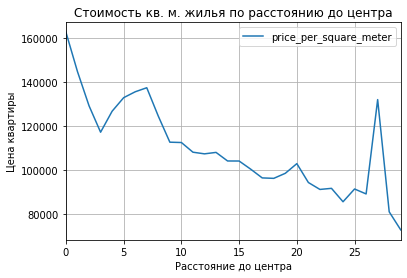

In [ ]:
df['to_center_in_km'] = round(df['cityCenters_nearest'] / 1000)
df[df['locality_name'] == 'Санкт-Петербург'].pivot_table(index='to_center_in_km', values='price_per_square_meter').plot(grid=True)
plt.title('Стоимость кв. м. жилья по расстоянию до центра')
plt.xlabel('Расстояние до центра')
plt.ylabel('Цена квартиры')

plt.show();

После 7 км резко снижается цена квадратного метра. Предположу, что центр заканчивается после 7 км. На 27 км видим пик: скорее всего, там находится элитный пригородный поселок.

### Особенности квартир в центре <a id="downtownfacts"></a>

count    3336.000000
mean       85.496891
std        43.693655
min        12.000000
25%        55.600000
50%        76.000000
75%       103.625000
max       441.980000
Name: total_area, dtype: float64

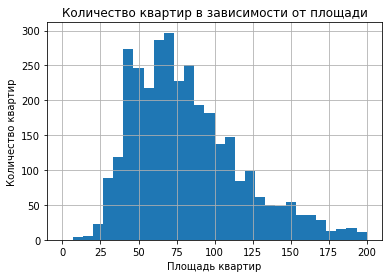

In [ ]:
df_c = df[(df['locality_name'] == 'Санкт-Петербург') & (df['to_center_in_km'] <= 7.0)]
display(df_c['total_area'].describe())
df_c['total_area'].hist(range=(0,200), bins=30)
plt.title('Количество квартир в зависимости от площади')
plt.xlabel('Площадь квартир')
plt.ylabel('Количество квартир')

plt.show();

Медианная площадь квартир в центре Петербурга - 76 кв. м., тогда как по всему датасету - 52 кв. м.

count    3.336000e+03
mean     1.105263e+07
std      6.813057e+06
min      1.600000e+06
25%      6.500000e+06
50%      8.900000e+06
75%      1.303327e+07
max      3.900000e+07
Name: last_price, dtype: float64

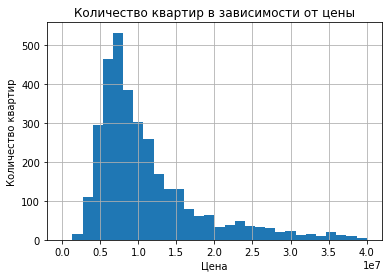

In [ ]:
display(df_c['last_price'].describe())
df_c['last_price'].hist(bins=30, range=(1.219000e+04, 4.000000e+07))
plt.title('Количество квартир в зависимости от цены')
plt.xlabel('Цена')
plt.ylabel('Количество квартир')

plt.show();

Медианная стоимость квартиры в центре почти в 2 раза выше чем по всему датасету - 8.9 млн против 4.65 млн. 

count    3336.000000
mean        2.752998
std         1.387292
min         0.000000
25%         2.000000
50%         3.000000
75%         3.000000
max        19.000000
Name: rooms, dtype: float64

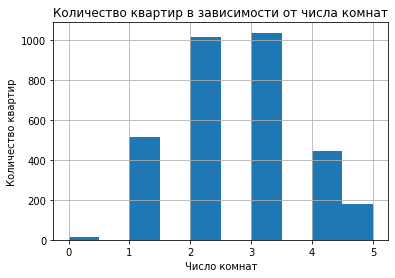

In [ ]:
display(df_c['rooms'].describe())
df_c['rooms'].hist(range=(0,5))
plt.title('Количество квартир в зависимости от числа комнат')
plt.xlabel('Число комнат')
plt.ylabel('Количество квартир')

plt.show();

В центре доля трехкомнатных выше, а однокомнатных - ниже, чем в общем датасете.

count    2162.000000
mean        3.100675
std         0.882275
min         2.400000
25%         2.800000
50%         3.000000
75%         3.267500
max        32.000000
Name: ceiling_height, dtype: float64

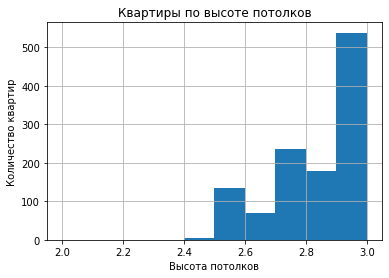

In [ ]:
display(df_c['ceiling_height'].describe())
df_c['ceiling_height'].hist(range=(2,3))
plt.title('Квартиры по высоте потолков')
plt.xlabel('Высота потолков')
plt.ylabel('Количество квартир')

plt.show();

В центре потолки выше: медиана в 3 метра против 2.65 метра в общем датасете.

0.7196016115399043

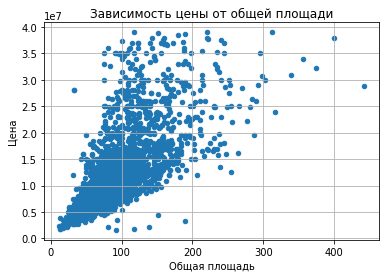

In [ ]:
display(df_c['total_area'].corr(df_c['last_price']))
df_c.plot(x='total_area', y='last_price', kind='scatter', grid=True)
plt.title('Зависимость цены от общей площади')
plt.xlabel('Общая площадь')
plt.ylabel('Цена')

plt.show();

Корреляция между площадью и ценой несколько ниже, чем в общем датасете: 0.72 против 0.79. Наверное, в центре чуть выше играет роль локация.

0.46574456430374034

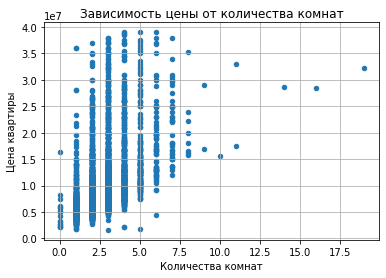

In [ ]:
display(df_c['rooms'].corr(df_c['last_price']))
df_c.plot(x='rooms', y='last_price', kind='scatter', grid=True)
plt.title('Зависимость цены от количества комнат')
plt.xlabel('Количества комнат')
plt.ylabel('Цена квартиры')

plt.show();

Зависимость цены недвижимости от количества комнат ниже, чем в общем датасете: 0,465 против 0,51.

In [ ]:
df_c.pivot_table(index='floor_category', values='last_price')

,last_price
floor_category,
другой,1.150299e+07
первый,8.080162e+06
последний,1.114123e+07


Похожи на результаты общего датасета: квартиры на первых этажах примерно на треть дешевле квартир на других этажах, в том числе последнем.

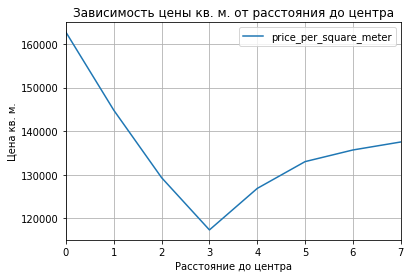

In [ ]:
df_c.pivot_table(index='to_center_in_km', values='price_per_square_meter').plot(grid=True)
plt.title('Зависимость цены кв. м. от расстояния до центра')
plt.xlabel('Расстояние до центра')
plt.ylabel('Цена кв. м.')

plt.show();

Любопытная зависимость: сначала стоимость снижается при удалении от центра до 3 км, потом повышается вплоть до 7 км.

In [ ]:
display(df_c.pivot_table(index='weekday', values='last_price'))
display(df_c.pivot_table(index='month', values='last_price'))
display(df_c.pivot_table(index='year', values='last_price'))

,last_price
weekday,
0,1.108845e+07
1,1.071668e+07
2,1.145906e+07
3,1.112845e+07
4,1.090027e+07
5,1.020363e+07
6,1.203318e+07


,last_price
month,
1,1.233397e+07
2,1.119714e+07
3,1.118660e+07
4,1.062497e+07
5,1.046160e+07
6,1.096673e+07
7,1.088781e+07
8,1.139332e+07
9,1.064276e+07


,last_price
year,
2014,1.541168e+07
2015,1.154666e+07
2016,1.085593e+07
2017,1.102123e+07
2018,1.076320e+07
2019,1.158658e+07


Несколько отличается от общего датасета зависимость цены от года: резкое снижение в 2015 году, потом то снижение, то небольшое повышение. Тогда как в общем датасете до 2018-го цены снижались стабильно. По всей видимости, цены на недвижимость в центре более устойчивы.

### Вывод

- Медианная стоимость квартир в центре выше в 2 раза, а площадь - в 1.5 раза.
- Потолки в центре выше: 3 против 2.4 м
- Зависимость цены квартиры от количества комнат, площади и этажа примерно такая же
- В центре доля трехкомнатных квартир выше, а однокомнатных - ниже
- Цена квартир в центре меньше подвержена рыночным колебаниям

### Шаг 5. Общий вывод <a id="generalconclusion"></a>

- Удалили строки с аномальной ценой. Редкие и выбивающиеся значения в других столбцах не трогали:  Пропусков много: только в 10 столбцах из 22 данные полны. Пропуски в большинстве столбцов тоже не трогали.
- Цена квартир в Санкт-Петербурге и соседних населенных пунктах резко упала после 2014 года и стала восстанавливаться только в 2019 году.
- В центре Санкт-Петербурга стоимость квартир после 2014 года находилась примерно на одном и том же уровне, во всем регионе в целом - снижалась.
- Квартиры на первом этаже примерно на 30% дешевле.
- Центр Петербурга заканчивается на 7-м километре от центра, потому что дальше стоимость квадратного метра стабильно падает.
- Больше всего на стоимость квартиры влияет ее площадь: коэффициент корреляции Пирсона около 0.79.
- В поселке "Зеленый лис" и Зеленогорске стоимость квадратного метра выше, чем в Петербурге - видимо, это элитные населенные пункты.